## Import Modules

In [1]:
# Import all the required modules
import math
from collections import OrderedDict
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

if 'google.colab' in sys.modules:
    # Download the repo from GitHub
    print("Downloading repository on Colab...")
    !git clone https://github.com/Shilpaj1994/ERA.git

    # Import files from the downloaded repository
    sys.path.insert(0,'./ERA/Session9/')

Cloning into 'ERA'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 203 (delta 73), reused 177 (delta 47), pack-reused 0
Receiving objects: 100% (203/203), 27.43 MiB | 27.06 MiB/s, done.
Resolving deltas: 100% (73/73), done.


# Dataset Analysis

## Extract and Load the Data

In [2]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 49190278.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Data Statistics

[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


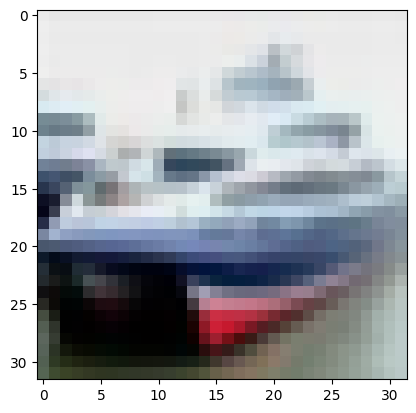

In [3]:
from utils import get_cifar_statistics

get_cifar_statistics(train)
get_cifar_statistics(test, data_set_type="Test")

## Parameters

In [4]:
BATCH_SIZE = 512
EPOCHS = 100
DISPLAY_SAMPLES = 20
LEARNING_RATE = 0.112
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
MAX_LR = 0.1
STEPS_PER_EPOCH = math.ceil(50_000/BATCH_SIZE)

## Visualize Training Data

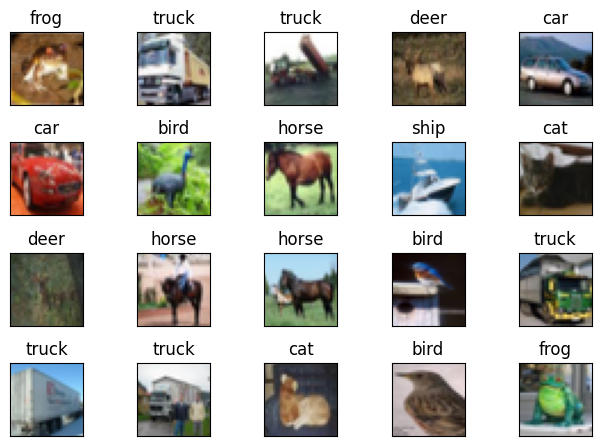

In [5]:
from visualize import display_cifar_data_samples

sample, _ = train[4]
display_cifar_data_samples(train, DISPLAY_SAMPLES, classes)

## Transformations

In [6]:
# Train Phase transformations
train_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=0.2),
    'horizontalflip': A.HorizontalFlip(),
    'rotation': A.Rotate(15),
    'shiftscalerotate': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15),
    'randombrightness': A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=0.1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

# Test Phase transformations
test_set_transforms = {
    'normalize': A.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2()
}

train_transforms = A.Compose(train_set_transforms.values())
test_transforms = A.Compose(test_set_transforms.values())

In [7]:
from datasets import AlbumDataset

train_set = AlbumDataset('./data', train=True, download=True, transform=train_transforms)
test_set = AlbumDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Visualize Augmentations

Files already downloaded and verified


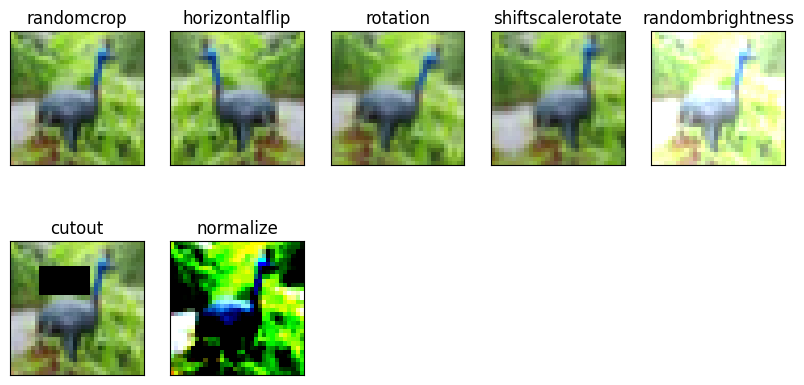

In [8]:
from visualize import visualize_cifar_augmentation

aug_train = AlbumDataset('./data', train=True, download=True)

aug_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=1),
    'horizontalflip': A.HorizontalFlip(p=1),
    'rotation': A.Rotate(15, p=1),
    'shiftscalerotate': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=1),
    'randombrightness': A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None, p=1),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

visualize_cifar_augmentation(aug_train, aug_set_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [9]:
SEED = 8

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


## Model and its Parameters

In [10]:
from model import Session9Net
from utils import get_summary

get_summary(Session9Net(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 15, 15]           9,216
             ReLU-10           [-1, 32, 15, 15]               0
      BatchNorm2d-11           [-1, 32, 15, 15]              64
          Dropout-12           [-1, 32, 15, 15]               0
           Conv2d-13           [-1, 38, 15, 15]          10,944
             ReLU-14           [-1, 38,

## Model Training and Testing

In [11]:
from training_utils import train, test

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


# Put the model on selected device
model = Session9Net().to(device)

# Optimization algorithm to update the weights
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Scheduler to change the learning rate after specific number of epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

# New Line
criterion = F.nll_loss

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.8128 Batch_id=97 Accuracy=22.88: 100%|██████████| 98/98 [00:11<00:00,  8.43it/s]


Test set: Average loss: 1.7001, Accuracy: 3676/10000 (36.76%)

Epoch 2


Train: Loss=1.5683 Batch_id=97 Accuracy=35.32: 100%|██████████| 98/98 [00:11<00:00,  8.35it/s]


Test set: Average loss: 1.4805, Accuracy: 4507/10000 (45.07%)

Epoch 3


Train: Loss=1.5898 Batch_id=97 Accuracy=40.73: 100%|██████████| 98/98 [00:12<00:00,  7.94it/s]


Test set: Average loss: 1.4027, Accuracy: 4796/10000 (47.96%)

Epoch 4


Train: Loss=1.4394 Batch_id=97 Accuracy=43.93: 100%|██████████| 98/98 [00:11<00:00,  8.85it/s]


Test set: Average loss: 1.2764, Accuracy: 5364/10000 (53.64%)

Epoch 5


Train: Loss=1.3943 Batch_id=97 Accuracy=47.01: 100%|██████████| 98/98 [00:10<00:00,  9.03it/s]


Test set: Average loss: 1.2216, Accuracy: 5546/10000 (55.46%)

Epoch 6


Train: Loss=1.4417 Batch_id=97 Accuracy=49.59: 100%|██████████| 98/98 [00:10<00:00,  9.66it/s]


Test set: Average loss: 1.2125, Accuracy: 5660/10000 (56.60%)

Epoch 7


Train: Loss=1.3024 Batch_id=97 Accuracy=50.95: 100%|██████████| 98/98 [00:10<00:00,  9.63it/s]


Test set: Average loss: 1.1413, Accuracy: 5883/10000 (58.83%)

Epoch 8


Train: Loss=1.4151 Batch_id=97 Accuracy=52.89: 100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


Test set: Average loss: 1.0996, Accuracy: 6078/10000 (60.78%)

Epoch 9


Train: Loss=1.2338 Batch_id=97 Accuracy=54.56: 100%|██████████| 98/98 [00:10<00:00,  9.12it/s]


Test set: Average loss: 1.0457, Accuracy: 6271/10000 (62.71%)

Epoch 10


Train: Loss=1.1867 Batch_id=97 Accuracy=56.29: 100%|██████████| 98/98 [00:11<00:00,  8.81it/s]


Test set: Average loss: 0.9680, Accuracy: 6590/10000 (65.90%)

Epoch 11


Train: Loss=1.1678 Batch_id=97 Accuracy=57.57: 100%|██████████| 98/98 [00:10<00:00,  8.96it/s]


Test set: Average loss: 0.9709, Accuracy: 6536/10000 (65.36%)

Epoch 12


Train: Loss=1.0841 Batch_id=97 Accuracy=58.53: 100%|██████████| 98/98 [00:11<00:00,  8.79it/s]


Test set: Average loss: 0.9620, Accuracy: 6624/10000 (66.24%)

Epoch 13


Train: Loss=1.1302 Batch_id=97 Accuracy=59.52: 100%|██████████| 98/98 [00:12<00:00,  7.98it/s]


Test set: Average loss: 0.8747, Accuracy: 6924/10000 (69.24%)

Epoch 14


Train: Loss=1.0532 Batch_id=97 Accuracy=60.97: 100%|██████████| 98/98 [00:11<00:00,  8.81it/s]


Test set: Average loss: 0.8435, Accuracy: 7032/10000 (70.32%)

Epoch 15


Train: Loss=1.1135 Batch_id=97 Accuracy=61.41: 100%|██████████| 98/98 [00:11<00:00,  8.84it/s]


Test set: Average loss: 0.9090, Accuracy: 6851/10000 (68.51%)

Epoch 16


Train: Loss=1.0710 Batch_id=97 Accuracy=62.49: 100%|██████████| 98/98 [00:11<00:00,  8.88it/s]


Test set: Average loss: 0.8161, Accuracy: 7097/10000 (70.97%)

Epoch 17


Train: Loss=0.8962 Batch_id=97 Accuracy=62.95: 100%|██████████| 98/98 [00:11<00:00,  8.62it/s]


Test set: Average loss: 0.7891, Accuracy: 7218/10000 (72.18%)

Epoch 18


Train: Loss=1.0285 Batch_id=97 Accuracy=64.27: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Test set: Average loss: 0.7503, Accuracy: 7364/10000 (73.64%)

Epoch 19


Train: Loss=0.8986 Batch_id=97 Accuracy=64.25: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s]


Test set: Average loss: 0.7299, Accuracy: 7424/10000 (74.24%)

Epoch 20


Train: Loss=0.9281 Batch_id=97 Accuracy=65.45: 100%|██████████| 98/98 [00:11<00:00,  8.42it/s]


Test set: Average loss: 0.8111, Accuracy: 7202/10000 (72.02%)

Epoch 21


Train: Loss=0.8030 Batch_id=97 Accuracy=65.49: 100%|██████████| 98/98 [00:09<00:00,  9.81it/s]


Test set: Average loss: 0.6878, Accuracy: 7576/10000 (75.76%)

Epoch 22


Train: Loss=0.9743 Batch_id=97 Accuracy=65.88: 100%|██████████| 98/98 [00:11<00:00,  8.89it/s]


Test set: Average loss: 0.7405, Accuracy: 7417/10000 (74.17%)

Epoch 23


Train: Loss=0.9771 Batch_id=97 Accuracy=66.67: 100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


Test set: Average loss: 0.7169, Accuracy: 7551/10000 (75.51%)

Epoch 24


Train: Loss=0.8444 Batch_id=97 Accuracy=67.03: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Test set: Average loss: 0.7067, Accuracy: 7563/10000 (75.63%)

Epoch 25


Train: Loss=0.8027 Batch_id=97 Accuracy=67.29: 100%|██████████| 98/98 [00:11<00:00,  8.82it/s]


Test set: Average loss: 0.6750, Accuracy: 7665/10000 (76.65%)

Epoch 26


Train: Loss=0.9589 Batch_id=97 Accuracy=67.81: 100%|██████████| 98/98 [00:10<00:00,  8.94it/s]


Test set: Average loss: 0.6554, Accuracy: 7705/10000 (77.05%)

Epoch 27


Train: Loss=0.8876 Batch_id=97 Accuracy=68.02: 100%|██████████| 98/98 [00:11<00:00,  8.57it/s]


Test set: Average loss: 0.6443, Accuracy: 7777/10000 (77.77%)

Epoch 28


Train: Loss=0.8549 Batch_id=97 Accuracy=68.47: 100%|██████████| 98/98 [00:12<00:00,  7.93it/s]


Test set: Average loss: 0.6383, Accuracy: 7787/10000 (77.87%)

Epoch 29


Train: Loss=0.8464 Batch_id=97 Accuracy=68.73: 100%|██████████| 98/98 [00:11<00:00,  8.73it/s]


Test set: Average loss: 0.6431, Accuracy: 7771/10000 (77.71%)

Epoch 30


Train: Loss=0.8605 Batch_id=97 Accuracy=68.89: 100%|██████████| 98/98 [00:11<00:00,  8.89it/s]


Test set: Average loss: 0.6726, Accuracy: 7684/10000 (76.84%)

Epoch 31


Train: Loss=0.8335 Batch_id=97 Accuracy=69.33: 100%|██████████| 98/98 [00:10<00:00,  8.93it/s]


Test set: Average loss: 0.5992, Accuracy: 7917/10000 (79.17%)

Epoch 32


Train: Loss=0.9518 Batch_id=97 Accuracy=69.66: 100%|██████████| 98/98 [00:11<00:00,  8.48it/s]


Test set: Average loss: 0.5851, Accuracy: 7957/10000 (79.57%)

Epoch 33


Train: Loss=0.7904 Batch_id=97 Accuracy=69.92: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


Test set: Average loss: 0.6168, Accuracy: 7856/10000 (78.56%)

Epoch 34


Train: Loss=0.9044 Batch_id=97 Accuracy=69.82: 100%|██████████| 98/98 [00:10<00:00,  9.32it/s]


Test set: Average loss: 0.6293, Accuracy: 7778/10000 (77.78%)

Epoch 35


Train: Loss=0.9553 Batch_id=97 Accuracy=70.19: 100%|██████████| 98/98 [00:10<00:00,  9.78it/s]


Test set: Average loss: 0.6154, Accuracy: 7891/10000 (78.91%)

Epoch 36


Train: Loss=0.9243 Batch_id=97 Accuracy=70.25: 100%|██████████| 98/98 [00:10<00:00,  9.21it/s]


Test set: Average loss: 0.6081, Accuracy: 7893/10000 (78.93%)

Epoch 37


Train: Loss=0.8195 Batch_id=97 Accuracy=70.56: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


Test set: Average loss: 0.5820, Accuracy: 8000/10000 (80.00%)

Epoch 38


Train: Loss=0.8800 Batch_id=97 Accuracy=70.84: 100%|██████████| 98/98 [00:11<00:00,  8.25it/s]


Test set: Average loss: 0.6025, Accuracy: 7953/10000 (79.53%)

Epoch 39


Train: Loss=0.7229 Batch_id=97 Accuracy=71.19: 100%|██████████| 98/98 [00:10<00:00,  8.95it/s]


Test set: Average loss: 0.5786, Accuracy: 8035/10000 (80.35%)

Epoch 40


Train: Loss=0.8756 Batch_id=97 Accuracy=71.10: 100%|██████████| 98/98 [00:11<00:00,  8.66it/s]


Test set: Average loss: 0.5675, Accuracy: 8061/10000 (80.61%)

Epoch 41


Train: Loss=0.8333 Batch_id=97 Accuracy=71.20: 100%|██████████| 98/98 [00:11<00:00,  8.76it/s]


Test set: Average loss: 0.5939, Accuracy: 7940/10000 (79.40%)

Epoch 42


Train: Loss=0.8202 Batch_id=97 Accuracy=71.43: 100%|██████████| 98/98 [00:11<00:00,  8.36it/s]


Test set: Average loss: 0.5651, Accuracy: 8070/10000 (80.70%)

Epoch 43


Train: Loss=0.7468 Batch_id=97 Accuracy=71.38: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s]


Test set: Average loss: 0.5478, Accuracy: 8128/10000 (81.28%)

Epoch 44


Train: Loss=1.0229 Batch_id=97 Accuracy=71.59: 100%|██████████| 98/98 [00:11<00:00,  8.86it/s]


Test set: Average loss: 0.5492, Accuracy: 8133/10000 (81.33%)

Epoch 45


Train: Loss=0.8489 Batch_id=97 Accuracy=71.83: 100%|██████████| 98/98 [00:11<00:00,  8.87it/s]


Test set: Average loss: 0.5326, Accuracy: 8158/10000 (81.58%)

Epoch 46


Train: Loss=0.7223 Batch_id=97 Accuracy=72.24: 100%|██████████| 98/98 [00:11<00:00,  8.79it/s]


Test set: Average loss: 0.5386, Accuracy: 8141/10000 (81.41%)

Epoch 47


Train: Loss=0.7812 Batch_id=97 Accuracy=72.32: 100%|██████████| 98/98 [00:11<00:00,  8.24it/s]


Test set: Average loss: 0.5742, Accuracy: 8055/10000 (80.55%)

Epoch 48


Train: Loss=0.8985 Batch_id=97 Accuracy=72.33: 100%|██████████| 98/98 [00:11<00:00,  8.25it/s]


Test set: Average loss: 0.5677, Accuracy: 8071/10000 (80.71%)

Epoch 49


Train: Loss=0.8020 Batch_id=97 Accuracy=72.31: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s]


Test set: Average loss: 0.5612, Accuracy: 8078/10000 (80.78%)

Epoch 50


Train: Loss=0.6832 Batch_id=97 Accuracy=72.53: 100%|██████████| 98/98 [00:10<00:00,  9.72it/s]


Test set: Average loss: 0.5341, Accuracy: 8151/10000 (81.51%)

Epoch 51


Train: Loss=0.7262 Batch_id=97 Accuracy=72.59: 100%|██████████| 98/98 [00:10<00:00,  9.19it/s]


Test set: Average loss: 0.5556, Accuracy: 8085/10000 (80.85%)

Epoch 52


Train: Loss=0.8090 Batch_id=97 Accuracy=72.77: 100%|██████████| 98/98 [00:11<00:00,  8.43it/s]


Test set: Average loss: 0.5124, Accuracy: 8252/10000 (82.52%)

Epoch 53


Train: Loss=0.8490 Batch_id=97 Accuracy=72.78: 100%|██████████| 98/98 [00:12<00:00,  8.15it/s]


Test set: Average loss: 0.5074, Accuracy: 8282/10000 (82.82%)

Epoch 54


Train: Loss=0.8463 Batch_id=97 Accuracy=72.92: 100%|██████████| 98/98 [00:12<00:00,  7.95it/s]


Test set: Average loss: 0.5309, Accuracy: 8151/10000 (81.51%)

Epoch 55


Train: Loss=0.7041 Batch_id=97 Accuracy=73.02: 100%|██████████| 98/98 [00:11<00:00,  8.85it/s]


Test set: Average loss: 0.5168, Accuracy: 8200/10000 (82.00%)

Epoch 56


Train: Loss=0.7372 Batch_id=97 Accuracy=73.19: 100%|██████████| 98/98 [00:11<00:00,  8.63it/s]


Test set: Average loss: 0.5244, Accuracy: 8172/10000 (81.72%)

Epoch 57


Train: Loss=0.7869 Batch_id=97 Accuracy=73.11: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


Test set: Average loss: 0.5197, Accuracy: 8189/10000 (81.89%)

Epoch 58


Train: Loss=0.7151 Batch_id=97 Accuracy=73.33: 100%|██████████| 98/98 [00:11<00:00,  8.40it/s]


Test set: Average loss: 0.5127, Accuracy: 8252/10000 (82.52%)

Epoch 59


Train: Loss=0.7445 Batch_id=97 Accuracy=73.81: 100%|██████████| 98/98 [00:11<00:00,  8.80it/s]


Test set: Average loss: 0.5281, Accuracy: 8176/10000 (81.76%)

Epoch 60


Train: Loss=0.7408 Batch_id=97 Accuracy=73.24: 100%|██████████| 98/98 [00:11<00:00,  8.79it/s]


Test set: Average loss: 0.5368, Accuracy: 8181/10000 (81.81%)

Epoch 61


Train: Loss=0.8158 Batch_id=97 Accuracy=73.53: 100%|██████████| 98/98 [00:11<00:00,  8.75it/s]


Test set: Average loss: 0.5095, Accuracy: 8234/10000 (82.34%)

Epoch 62


Train: Loss=0.6766 Batch_id=97 Accuracy=73.75: 100%|██████████| 98/98 [00:12<00:00,  7.98it/s]


Test set: Average loss: 0.4934, Accuracy: 8293/10000 (82.93%)

Epoch 63


Train: Loss=0.7476 Batch_id=97 Accuracy=73.61: 100%|██████████| 98/98 [00:11<00:00,  8.57it/s]


Test set: Average loss: 0.5238, Accuracy: 8211/10000 (82.11%)

Epoch 64


Train: Loss=0.7750 Batch_id=97 Accuracy=73.92: 100%|██████████| 98/98 [00:11<00:00,  8.81it/s]


Test set: Average loss: 0.4917, Accuracy: 8334/10000 (83.34%)

Epoch 65


Train: Loss=0.7588 Batch_id=97 Accuracy=74.01: 100%|██████████| 98/98 [00:10<00:00,  9.02it/s]


Test set: Average loss: 0.4953, Accuracy: 8307/10000 (83.07%)

Epoch 66


Train: Loss=0.7190 Batch_id=97 Accuracy=73.80: 100%|██████████| 98/98 [00:10<00:00,  8.98it/s]


Test set: Average loss: 0.5055, Accuracy: 8280/10000 (82.80%)

Epoch 67


Train: Loss=0.7431 Batch_id=97 Accuracy=74.47: 100%|██████████| 98/98 [00:12<00:00,  8.05it/s]


Test set: Average loss: 0.4878, Accuracy: 8325/10000 (83.25%)

Epoch 68


Train: Loss=0.7787 Batch_id=97 Accuracy=74.73: 100%|██████████| 98/98 [00:10<00:00,  8.99it/s]


Test set: Average loss: 0.4882, Accuracy: 8319/10000 (83.19%)

Epoch 69


Train: Loss=0.7316 Batch_id=97 Accuracy=74.69: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s]


Test set: Average loss: 0.4974, Accuracy: 8272/10000 (82.72%)

Epoch 70


Train: Loss=0.7355 Batch_id=97 Accuracy=74.61: 100%|██████████| 98/98 [00:10<00:00,  9.12it/s]


Test set: Average loss: 0.4757, Accuracy: 8392/10000 (83.92%)

Epoch 71


Train: Loss=0.7610 Batch_id=97 Accuracy=74.76: 100%|██████████| 98/98 [00:13<00:00,  7.48it/s]


Test set: Average loss: 0.4871, Accuracy: 8356/10000 (83.56%)

Epoch 72


Train: Loss=0.7328 Batch_id=97 Accuracy=74.86: 100%|██████████| 98/98 [00:11<00:00,  8.30it/s]


Test set: Average loss: 0.4808, Accuracy: 8336/10000 (83.36%)

Epoch 73


Train: Loss=0.7469 Batch_id=97 Accuracy=74.93: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s]


Test set: Average loss: 0.4955, Accuracy: 8309/10000 (83.09%)

Epoch 74


Train: Loss=0.7969 Batch_id=97 Accuracy=75.20: 100%|██████████| 98/98 [00:11<00:00,  8.87it/s]


Test set: Average loss: 0.4758, Accuracy: 8384/10000 (83.84%)

Epoch 75


Train: Loss=0.9140 Batch_id=97 Accuracy=75.01: 100%|██████████| 98/98 [00:11<00:00,  8.64it/s]


Test set: Average loss: 0.4661, Accuracy: 8392/10000 (83.92%)

Epoch 76


Train: Loss=0.7065 Batch_id=97 Accuracy=75.06: 100%|██████████| 98/98 [00:11<00:00,  8.22it/s]


Test set: Average loss: 0.4700, Accuracy: 8364/10000 (83.64%)

Epoch 77


Train: Loss=0.6489 Batch_id=97 Accuracy=75.45: 100%|██████████| 98/98 [00:12<00:00,  7.96it/s]


Test set: Average loss: 0.4756, Accuracy: 8367/10000 (83.67%)

Epoch 78


Train: Loss=0.7608 Batch_id=97 Accuracy=75.45: 100%|██████████| 98/98 [00:11<00:00,  8.57it/s]


Test set: Average loss: 0.4664, Accuracy: 8394/10000 (83.94%)

Epoch 79


Train: Loss=0.7832 Batch_id=97 Accuracy=75.43: 100%|██████████| 98/98 [00:11<00:00,  8.47it/s]


Test set: Average loss: 0.4726, Accuracy: 8369/10000 (83.69%)

Epoch 80


Train: Loss=0.7189 Batch_id=97 Accuracy=75.62: 100%|██████████| 98/98 [00:11<00:00,  8.66it/s]


Test set: Average loss: 0.4609, Accuracy: 8414/10000 (84.14%)

Epoch 81


Train: Loss=0.6959 Batch_id=97 Accuracy=75.83: 100%|██████████| 98/98 [00:12<00:00,  8.01it/s]


Test set: Average loss: 0.4607, Accuracy: 8407/10000 (84.07%)

Epoch 82


Train: Loss=0.6430 Batch_id=97 Accuracy=76.14: 100%|██████████| 98/98 [00:12<00:00,  8.05it/s]


Test set: Average loss: 0.4647, Accuracy: 8391/10000 (83.91%)

Epoch 83


Train: Loss=0.6055 Batch_id=97 Accuracy=75.89: 100%|██████████| 98/98 [00:11<00:00,  8.54it/s]


Test set: Average loss: 0.4561, Accuracy: 8454/10000 (84.54%)

Epoch 84


Train: Loss=0.7519 Batch_id=97 Accuracy=76.30: 100%|██████████| 98/98 [00:11<00:00,  8.59it/s]


Test set: Average loss: 0.4530, Accuracy: 8452/10000 (84.52%)

Epoch 85


Train: Loss=0.6549 Batch_id=97 Accuracy=76.70: 100%|██████████| 98/98 [00:11<00:00,  8.53it/s]


Test set: Average loss: 0.4457, Accuracy: 8456/10000 (84.56%)

Epoch 86


Train: Loss=0.7269 Batch_id=97 Accuracy=76.49: 100%|██████████| 98/98 [00:12<00:00,  7.72it/s]


Test set: Average loss: 0.4494, Accuracy: 8459/10000 (84.59%)

Epoch 87


Train: Loss=0.6895 Batch_id=97 Accuracy=76.53: 100%|██████████| 98/98 [00:11<00:00,  8.27it/s]


Test set: Average loss: 0.4423, Accuracy: 8487/10000 (84.87%)

Epoch 88


Train: Loss=0.6968 Batch_id=97 Accuracy=76.87: 100%|██████████| 98/98 [00:12<00:00,  7.76it/s]


Test set: Average loss: 0.4461, Accuracy: 8473/10000 (84.73%)

Epoch 89


Train: Loss=0.6813 Batch_id=97 Accuracy=76.83: 100%|██████████| 98/98 [00:10<00:00,  8.96it/s]


Test set: Average loss: 0.4396, Accuracy: 8470/10000 (84.70%)

Epoch 90


Train: Loss=0.7501 Batch_id=97 Accuracy=76.62: 100%|██████████| 98/98 [00:10<00:00,  8.99it/s]


Test set: Average loss: 0.4401, Accuracy: 8478/10000 (84.78%)

Epoch 91


Train: Loss=0.6193 Batch_id=97 Accuracy=77.20: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Test set: Average loss: 0.4412, Accuracy: 8464/10000 (84.64%)

Epoch 92


Train: Loss=0.6697 Batch_id=97 Accuracy=77.05: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s]


Test set: Average loss: 0.4360, Accuracy: 8500/10000 (85.00%)

Epoch 93


Train: Loss=0.7059 Batch_id=97 Accuracy=77.22: 100%|██████████| 98/98 [00:10<00:00,  9.32it/s]


Test set: Average loss: 0.4360, Accuracy: 8487/10000 (84.87%)

Epoch 94


Train: Loss=0.6166 Batch_id=97 Accuracy=77.51: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s]


Test set: Average loss: 0.4331, Accuracy: 8508/10000 (85.08%)

Epoch 95


Train: Loss=0.6717 Batch_id=97 Accuracy=77.19: 100%|██████████| 98/98 [00:11<00:00,  8.58it/s]


Test set: Average loss: 0.4299, Accuracy: 8521/10000 (85.21%)

Epoch 96


Train: Loss=0.6197 Batch_id=97 Accuracy=77.38: 100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


Test set: Average loss: 0.4325, Accuracy: 8521/10000 (85.21%)

Epoch 97


Train: Loss=0.6084 Batch_id=97 Accuracy=77.71: 100%|██████████| 98/98 [00:11<00:00,  8.87it/s]


Test set: Average loss: 0.4314, Accuracy: 8521/10000 (85.21%)

Epoch 98


Train: Loss=0.6672 Batch_id=97 Accuracy=77.42: 100%|██████████| 98/98 [00:10<00:00,  9.27it/s]


Test set: Average loss: 0.4323, Accuracy: 8511/10000 (85.11%)

Epoch 99


Train: Loss=0.5867 Batch_id=97 Accuracy=77.40: 100%|██████████| 98/98 [00:10<00:00,  9.57it/s]


Test set: Average loss: 0.4318, Accuracy: 8505/10000 (85.05%)

Epoch 100


Train: Loss=0.6222 Batch_id=97 Accuracy=77.40: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]


Test set: Average loss: 0.4315, Accuracy: 8500/10000 (85.00%)



## Visualize Train and Test - Loss and Accuracies

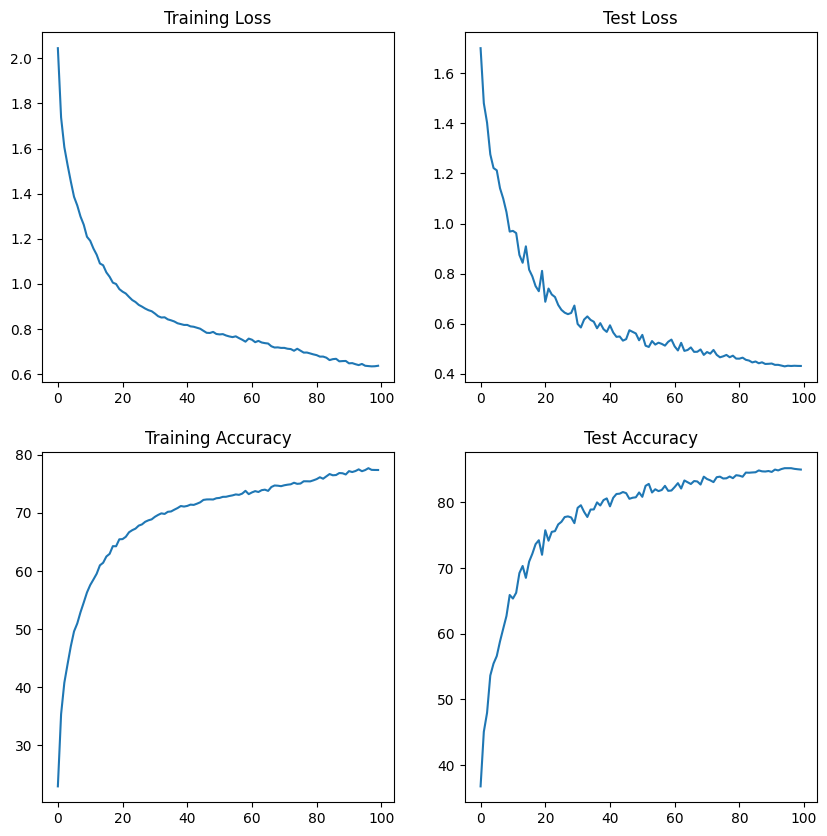

In [13]:
# Print loss and accuracy
from visualize import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

## Visualize Misclassified Images

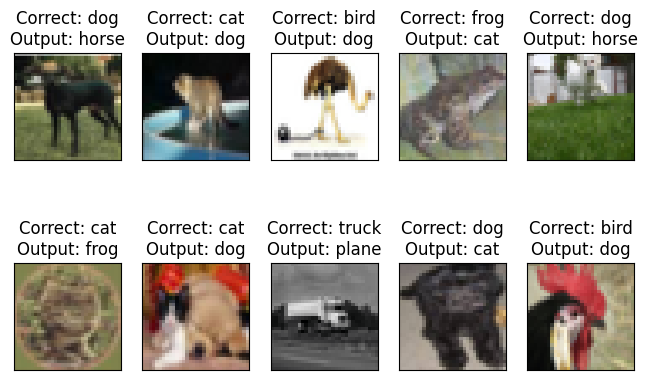

In [14]:
from utils import get_misclassified_data
from visualize import display_cifar_misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.4942/0.2466, -0.4851/0.2428, -0.4504/0.2615],
    std=[1/0.2466, 1/0.2428, 1/0.2615]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=10)